In [1]:
# ls

In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv('wave1_lip_dummies.csv', header=0, na_values=' ', index_col=0)
data.head()

,H1GI20,H1DA8,H1DA9,H1DA10,H1GH1,H1GH28,H1GH42,H1GH44,H1GH46,H1GH59A,...,BST90P13_3,BST90P24_1,BST90P24_2,BST90P24_3,BST90P24_4,BST90P24_5,BST90P24_6,BST90P26_1,BST90P26_2,BST90P26_3
AID,,,,,,,,,,,,,,,,,,,,,
57101310,11,33,4.0,0,4,5,4,5,5,6,...,0,0,0,0,0,0,1,0,0,1
57103869,12,24,6.0,7,4,2,4,4,5,6,...,1,0,1,0,0,0,0,0,1,0
57109625,8,14,7.0,3,1,2,2,4,4,5,...,0,0,1,0,0,0,0,0,0,1
57111071,8,35,12.0,2,2,4,3,3,3,5,...,0,0,1,0,0,0,0,0,0,1
57113943,9,10,5.0,4,3,4,3,4,5,6,...,1,0,1,0,0,0,0,1,0,0


In [4]:
data.shape

(5107, 500)

In [5]:
data.C_JOINT2.value_counts()

0    4686
1     421
Name: C_JOINT2, dtype: int64

#### Create CV Labels

In [6]:
data['cv_label'] = data.index

In [7]:
data.shape

(5107, 501)

In [8]:
# data.head()

In [9]:
target = data.C_JOINT2
target.head()

AID
57101310    1
57103869    0
57109625    0
57111071    0
57113943    0
Name: C_JOINT2, dtype: int64

In [10]:
del data['C_JOINT2']

In [11]:
del data['H1RP5'] #Question about pregnancy

In [12]:
del data['H1RP1']

#### Oversample to balance classes

In [13]:
# NB: If you use this you'll need to add the package first
# conda install -c glemaitre imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

In [14]:
ros = RandomOverSampler(random_state=7)

In [15]:
data_res, target_res = ros.fit_sample(data, target)

In [16]:
data_res.shape

(9372, 498)

In [17]:
target_res.shape

(9372,)

In [18]:
# Double check to make sure class counts have been balanced
unique, counts = np.unique(target_res, return_counts=True)
dict(zip(unique, counts))

{0: 4686, 1: 4686}

#### Create training and testing sets

In [19]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_res, target_res, test_size=0.2, random_state=7)#, stratify=target_res)

/Users/davidscroggins/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
cv_labels_train = X_train[:,[497]]
cv_labels_test = X_test[:,[497]]

In [21]:
X_train = np.delete(X_train, -1, 1)
X_test = np.delete(X_test, -1, 1)

In [22]:
# data_res[:,[503]]

In [23]:
# cv_labels = data_res[:,[503]] #Create array of cv_labels

In [24]:
# cv_labels

In [25]:
# data_res = np.delete(data_res, -1, 1) #Delete cv_labels from data array

In [26]:
# data_res.shape

In [27]:
from sklearn.cross_validation import LabelKFold
from sklearn.cross_validation import cross_val_predict

#### Cross-Validate predictions on new dataset

In [28]:
lkf_train = LabelKFold(cv_labels_train, n_folds=10)
lkf_test = LabelKFold(cv_labels_test, n_folds=10)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [30]:
rfclf = RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=10)

In [31]:
predicted = cross_val_predict(rfclf, X_train, y_train, cv=lkf_train)

In [32]:
print(classification_report(y_train, predicted))

             precision    recall  f1-score   support

          0       0.53      0.58      0.56      3723
          1       0.54      0.49      0.51      3774

avg / total       0.54      0.54      0.53      7497



#### Use GridSearchCV to tune parameters

In [33]:
# from sklearn.model_selection import GridSearchCV

In [34]:
# rfGridSearch = RandomForestClassifier()

In [35]:
# np.arange(1, 102, 10)

In [36]:
# parameters = {
#     'criterion' : ['entropy', 'gini'],
#     'max_depth' : np.arange(1, 11, 3),
#     'min_samples_leaf' : np.arange(1, 102, 20),
#     'min_samples_split' : np.arange(2, 103, 20),
#     "n_estimators" : np.arange(10, 101, 20)
# }

In [37]:
# gs = GridSearchCV(rfGridSearch, parameters, verbose=1, cv=lkf_train, n_jobs=-1, scoring='recall')

In [38]:
# %time _ = gs.fit(X_train, y_train)

In [39]:
# gs.best_params_

#### Test best parameters

In [40]:
# # ten fold, scoring recall, .38 minority, .54 overall
# rfclf2 = RandomForestClassifier(criterion='entropy', max_depth=1,
#                                 min_samples_leaf=11, min_samples_split=2,
#                                 n_estimators=30)

In [41]:
# # five fold, default scoring, .36 minority, .55 overall
# rfclf2 = RandomForestClassifier(criterion='entropy', max_depth=1,
#                                 min_samples_leaf=11, min_samples_split=12,
#                                 n_estimators=50)

In [42]:
# .46 minority, .55 overall
rfclf2 = RandomForestClassifier(criterion='entropy', max_depth=6,
                                min_samples_leaf=91, min_samples_split=72,
                                n_estimators=100)

In [43]:
rfclf2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=91,
            min_samples_split=72, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [44]:
# Repeat cross-validated testing
predicted2 = cross_val_predict(rfclf2, X_test, y_test, cv=lkf_test)

In [45]:
print(classification_report(y_test, predicted2))

             precision    recall  f1-score   support

          0       0.54      0.63      0.58       963
          1       0.53      0.44      0.48       912

avg / total       0.54      0.54      0.54      1875



In [46]:
cd graphics

/Users/davidscroggins/Google Drive/DePaul/csc478_machineLearning/csc478_project/csc478_initialModels/graphics


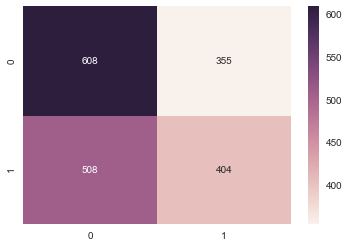

In [47]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
cm = confusion_matrix(y_test, predicted2)
hm = sb.heatmap(cm, annot=True, fmt="d")
fig = hm.get_figure()
fig.savefig("heatMap_oversampling_lip_randomForest")

In [48]:
importances = rfclf2.feature_importances_
indices = np.argsort(importances)[::-1]
features_list = list(data)
top_indices = indices[:10]
for i in top_indices:
    print features_list[i]

H1GI20
H1SE2
H1RP6
H1GH28
H1SE3
BST90P21
H1SE1
H1RP4
BST90P12
BST90P17


In [50]:
rfclf2.feature_importances_

array([  6.65794708e-02,   1.43790501e-02,   1.15974660e-02,
         6.72373126e-03,   2.79035070e-03,   2.72289873e-02,
         5.13048406e-03,   3.69357869e-03,   4.03158789e-03,
         3.50648104e-03,   2.87290020e-03,   5.23012996e-03,
         2.16531191e-02,   2.91902587e-02,   2.45729300e-02,
         3.00149176e-02,   2.57502042e-02,   5.84219933e-03,
         3.02742651e-03,   1.43680724e-03,   1.09767187e-03,
         3.70360227e-03,   3.94272469e-03,   5.20053097e-04,
         9.58333021e-04,   1.82714222e-04,   2.05744741e-03,
         1.99313298e-03,   4.80680744e-03,   7.88394335e-03,
         1.64259422e-03,   6.66343048e-03,   2.52973367e-03,
         4.22396290e-03,   1.94138011e-03,   2.12885015e-04,
         2.73764517e-03,   7.50356811e-04,   7.59100835e-03,
         8.19259958e-04,   5.06902613e-03,   7.17676188e-04,
         2.49073679e-03,   5.21956471e-03,   1.71686031e-03,
         4.52247015e-03,   5.41833384e-03,   5.74761867e-03,
         4.56420321e-03,

In [49]:
'''
Results for Depth 1 RF
H1GH28
BST90P17
H1GI20
H1RP4
H1MP4_1
H1RP6
H1SE3
H1TO39
H1DS7_1
BST90P06'''

'\nResults for Depth 1 RF\nH1GH28\nBST90P17\nH1GI20\nH1RP4\nH1MP4_1\nH1RP6\nH1SE3\nH1TO39\nH1DS7_1\nBST90P06'